In [4]:
import intake
from shapely.geometry import Point, Polygon
import geopandas as gpd
import numpy as np

In [5]:
basin_path = "Clip/CalSimIII_AllWatersheds_20200417_WGS84.shp"

In [6]:
def get_dataset(dataset_params):
    # Open catalog of available data sets using intake-esm package
    cat = intake.open_esm_datastore('https://cadcat.s3.amazonaws.com/cae-collection.json')
    cat_item = cat.search(
        activity_id=dataset_params["activity_id"],
        institution_id=dataset_params["institution_id"],
        table_id=dataset_params["table_id"], 
        variable_id=dataset_params["variable_id"],
        experiment_id=dataset_params["experiment_id"],
        grid_label=dataset_params["grid_label"],
        member_id=dataset_params["member_id"],
        source_id=dataset_params["source_id"],  
    )
    data_dict = cat_item.to_dataset_dict(
        xarray_open_kwargs={'consolidated': True},
        storage_options={'anon': True}
    )
    
    key = "{}.{}.{}.{}.{}.{}".format(
            dataset_params['activity_id'],
            dataset_params['institution_id'],
            dataset_params['source_id'],
            dataset_params['experiment_id'],
            dataset_params['table_id'],
            dataset_params['grid_label'],)
    
    return data_dict[key]

In [7]:
dataset_params = {
    "activity_id": "LOCA2",
    "institution_id": "UCSD",
    "table_id": "day",
    "variable_id": "pr",
    "experiment_id": "ssp245",
    "member_id": "r1i1p1f2",
    "source_id": "CNRM-ESM2-1",
    "grid_label": "d03",
}
ds = get_dataset(dataset_params)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
# https://geohackweek.github.io/nDarrays/05-aggregation/

In [5]:
# time slice
time_slice = (2022, 2023)
ds = ds.sel(time=slice(str(time_slice[0]), str(time_slice[1])))

In [10]:
ts = ds.pr[0]

In [11]:
# average for months
ds = ds.resample(time="M").mean() # where M is for months

In [40]:
ds.attrs['title']

'LOCA statistically downscaled climate model data, David W. Pierce, Scripps Institution of Oceanography'

In [13]:
# SPATIAL MASKING

In [18]:
def intersect(lat, lon, polygons):
    pt = Point(lon, lat)
    for i, row in polygons.iterrows():
        polygon = row.geometry
        #if pt.within(polygon):
        if polygon.contains(pt):
            return row.OBJECTID
            break
    return None

In [22]:
def create_mask(time_slice, polygons, bbox):
    # initialize an empty array with same shape as ds
    mask = np.empty((ds.dims['lat'], ds.dims['lon']), dtype="object")

    # populate the array
    for i, x in enumerate(time_slice.coords['lon']):
        lon = x.values
        print(lon)

        for j, y in enumerate(time_slice.coords['lat']):
            lat = y.values
            
            if bbox["top"] > lat > bbox["bottom"] and bbox["left"] < lon < bbox["right"]:

                mask[(ds.dims['lat'] - 1) - j, i] = intersect(lat, lon, polygons)
            else:
                mask[(ds.dims['lat'] - 1) - j, i] = None

    return mask

In [ ]:
data = gpd.read_file(basin_path)
polygons = data[['OBJECTID', 'geometry']]
bbox = {
    "top": 42.5,
    "bottom": 34.7,
    "left": -123.1,
    "right": -117.9,
}
mask = create_mask(ts, polygons, bbox)

In [24]:
mask

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [29]:
with open("Clip/mask.npy", "wb") as f:
    np.save(f, mask)

In [6]:
with open("Clip/mask.npy", "rb") as g:
   shp_mask = np.load(g, allow_pickle=True)

In [42]:
shp_mask

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [19]:
print(f"{mask[0, 0]} {mask[0, 1]}")
print(f"{mask[1, 0]} {mask[1, 1]}")
print()
print(f"{mask[494, 558]}")

None None
None None

None


In [7]:
flipped_shp_mask = np.flip(shp_mask, 1)

In [16]:
mask = flipped_shp_mask
print(f"{mask[0, 0]} {mask[0, 1]}")
print(f"{mask[1, 0]} {mask[1, 1]}")
print()
print(f"{mask[494, 558]}")

None None
None None

None


In [12]:
ds.coords['mask'] = (('lat', 'lon'), flipped_shp_mask)

In [ ]:
ds['pr'].where(ds.mask is not None).plot()

In [ ]:
import datetime
print(datetime.datetime.now())

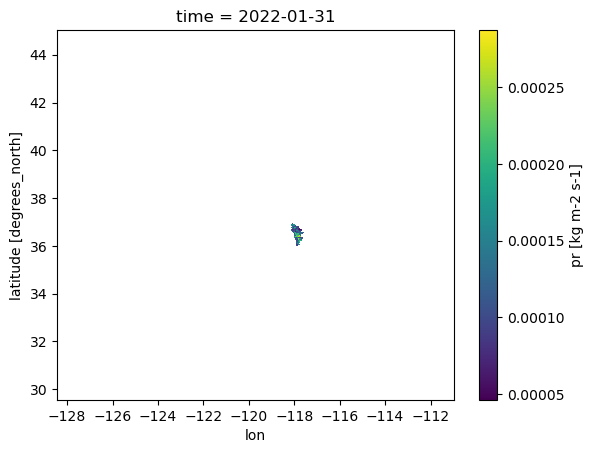

In [14]:
%matplotlib inline

#map_data = ds['pr'].sel(time='2022-01-31').where(ds.mask != None)
map_data = ds['pr'].sel(time='2022-01-31').where(ds.mask == 166)
#map_data = ds['pr'].sel(time='2022-11-30')
map_data.plot()

In [17]:
type(map_data)

xarray.core.dataarray.DataArray

In [16]:
map_data.to_netcdf("test_166.nc")

In [35]:
ds.coords

Coordinates:
  * lat      (lat) float32 29.58 29.61 29.64 29.67 ... 44.92 44.95 44.98 45.02
  * lon      (lon) float32 -128.4 -128.4 -128.4 -128.3 ... -111.0 -111.0 -111.0
  * time     (time) datetime64[ns] 2022-01-01T12:00:00 ... 2100-12-31T12:00:00
    mask     (lat, lon) object None None None None None ... None None None None

In [18]:
mask_values = flipped_shp_mask[flipped_shp_mask != np.array(None)]

In [20]:
oids = np.unique(mask_values)

In [23]:
type(oids[10])

int

In [24]:
oids

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 186, 188, 189, 190, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 217, 218, 219, 220, 221, 22

In [18]:
time_slice = ds.pr[0]

In [29]:
df = time_slice.to_dataframe()

In [30]:
df.head()

time  pr
lat       lon                                
29.578125 -128.421875 2022-01-01 12:00:00 NaN
          -128.390625 2022-01-01 12:00:00 NaN
          -128.359375 2022-01-01 12:00:00 NaN
          -128.328125 2022-01-01 12:00:00 NaN
          -128.296875 2022-01-01 12:00:00 NaN

In [32]:
df = df.reset_index()

In [34]:
df.head()

,lat,lon,time,pr
0,29.578125,-128.421875,2022-01-01 12:00:00,NaN
1,29.578125,-128.390625,2022-01-01 12:00:00,NaN
2,29.578125,-128.359375,2022-01-01 12:00:00,NaN
3,29.578125,-128.328125,2022-01-01 12:00:00,NaN
4,29.578125,-128.296875,2022-01-01 12:00:00,NaN


In [ ]:
point_data = ds[0].pr.to_dataframe()

In [ ]:
point_data.head()

In [64]:
ds.lat.attrs

{'long_name': 'latitude',
 'standard_name': 'latitude',
 'units': 'degrees_north'}

In [65]:
ds.lon.attrs

{}